In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Check if GPU is mounted
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


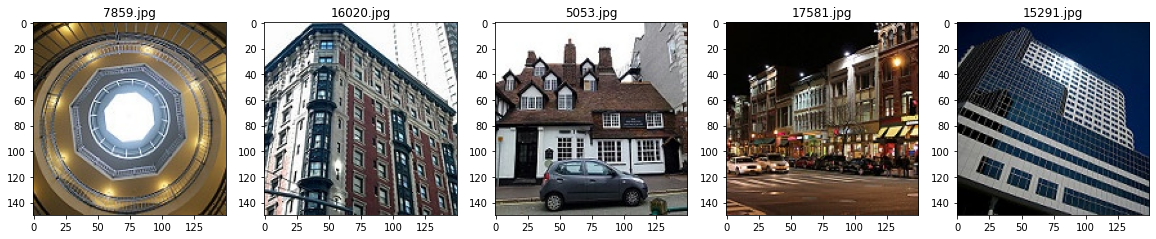

In [2]:
import random

#Load Building folders to display and check dir

plt.figure(figsize=(20,20))

building_folder='natural_scene_data/seg_train/seg_train/buildings/'

#Randomly display 5 house out of building folder
for i in range(5):
    file = random.choice(os.listdir(building_folder))
    image_path= os.path.join(building_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

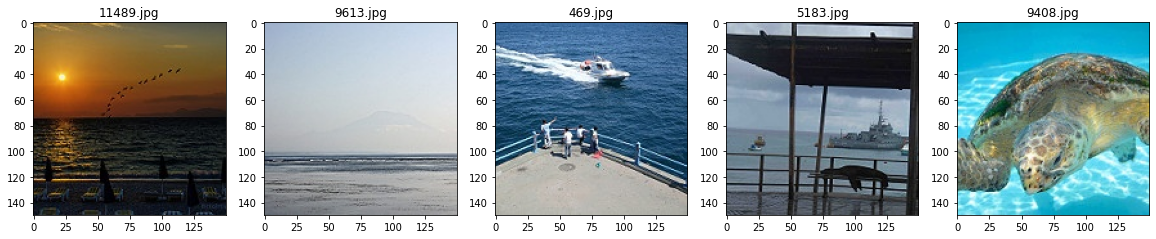

In [3]:
# Displaying Random 5 Beautiful Sea
sea_folder='natural_scene_data/seg_train/seg_train/sea/'
plt.figure(figsize=(20,20))
#Randomly display 5 house out of building folder
for i in range(5):
    file = random.choice(os.listdir(sea_folder))
    image_path= os.path.join(sea_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [4]:
IMG_WIDTH=200 # Later function to resize image
IMG_HEIGHT=200

# Create final dir for 5 folder of datasets, building, forest etc...
test_image_folder='natural_scene_data/seg_train/seg_train/'

In [5]:
# Function to easily process and create desired dataset
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[] # To append Classname
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name


img_data, class_name =create_dataset(test_image_folder)

In [6]:
# Generating class label dictionary later to map into Y_train dataset
class_dict={k: v for v, k in enumerate(np.unique(class_name))}
class_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [7]:
# Map the Y train set with dictionary class above
target_val=  [class_dict[class_name[i]] for i in range(len(class_name))]
len(target_val)

14034

In [8]:
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))
    
unique(target_val) # Check if the label mapping is correct

[0 1 2 3 4 5]


In [10]:
# Transfer Learning Method
from tensorflow.keras.applications import VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [11]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Transfer Learning Ending Layer
model = Sequential()
model.add(vgg16_base)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Creating the CNN Model
#CNN SELECTED because its nature best for image classification
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Conv2d high filter to less filter architecture
model = Sequential()
model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), padding='valid')) #Input shape 3 represent BGR?
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16,(3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output Layer
model.add(Dense(6, activation='softmax')) # Softmax selected for class > 2

In [12]:
img_data = np.array(img_data, np.float32)
target_val = np.array(list(map(int,target_val)), np.float32) # Target value is an array, need convert to np float 32

In [13]:
print(img_data.shape)
print(target_val.shape)

(14034, 200, 200, 3)
(14034,)


In [14]:
target_val

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

In [13]:
# Convert X train set
#img_data = np.array(img_data, np.float32)
#target_val = np.array(list(map(int,target_val)), np.float32) # Target value is an array, need convert to np float 32


#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model.fit(x=img_data, y=target_val, epochs=10, batch_size=32)

In [15]:
# Validation

validate_image_folder='natural_scene_data/seg_test/seg_test/'

validate_img_data, validate_class_name =create_dataset(validate_image_folder)

In [16]:
val_class_dict={k: v for v, k in enumerate(np.unique(validate_class_name))}
val_class_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [17]:
validate_target_val=  [val_class_dict[validate_class_name[i]] for i in range(len(validate_class_name))]
len(validate_target_val)

3000

In [18]:
validate_img_data = np.array(validate_img_data, np.float32)
validate_target_val = np.array(list(map(int,validate_target_val)), np.float32) # Target value is an array, need convert to np float 32

In [19]:
unique(validate_target_val) # Check if the label mapping is correct

[0. 1. 2. 3. 4. 5.]


In [21]:
# Customer optimizer
vgg16_base.trainable = False
adam_custom_lr = keras.optimizers.Adam(learning_rate=0.01)

# Early stopping since optimizer learning rate is super low
from tensorflow.keras import callbacks
#early_stopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
#                                        patience = 10, 
#                                        restore_best_weights = True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_custom_lr, metrics=['accuracy'])
history = model.fit(x=img_data, y=target_val, epochs=30, batch_size=32, validation_data=(validate_img_data, validate_target_val))

Epoch 1/30
439/439 [==============================] - 56s 106ms/step - loss: 0.5253 - accuracy: 0.8145 - val_loss: 0.3911 - val_accuracy: 0.8570
Epoch 2/30
439/439 [==============================] - 44s 101ms/step - loss: 0.3534 - accuracy: 0.8739 - val_loss: 0.3497 - val_accuracy: 0.8720
Epoch 3/30
439/439 [==============================] - 44s 100ms/step - loss: 0.3301 - accuracy: 0.8796 - val_loss: 0.3421 - val_accuracy: 0.8750
Epoch 4/30
439/439 [==============================] - 44s 101ms/step - loss: 0.3131 - accuracy: 0.8856 - val_loss: 0.3326 - val_accuracy: 0.8770
Epoch 5/30
439/439 [==============================] - 44s 101ms/step - loss: 0.3007 - accuracy: 0.8878 - val_loss: 0.3530 - val_accuracy: 0.8707
Epoch 6/30
439/439 [==============================] - 44s 100ms/step - loss: 0.2892 - accuracy: 0.8944 - val_loss: 0.3435 - val_accuracy: 0.8767
Epoch 7/30
439/439 [==============================] - 44s 101ms/step - loss: 0.2777 - accuracy: 0.8968 - val_loss: 0.3522 - val_ac

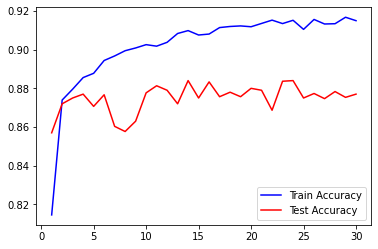

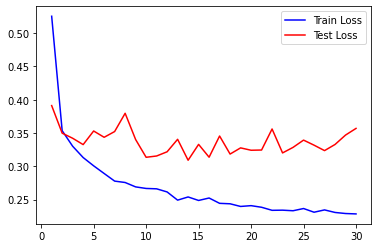

In [22]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc2)+1)

plt.plot(epochs, acc2, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Test Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss2, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Test Loss')
plt.legend()
plt.show()

In [24]:
# Test Transfer Learning Method
resnet50 = tf.keras.applications.resnet50.ResNet50(
                include_top=False,
                weights='imagenet',
                input_shape=(200, 200, 3),
            )

resnet50.summary()

94781440/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 50, 50, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 50, 50, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 50, 50, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 50, 50, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 25, 25, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization) 

                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block4_out (Activation)  (None, 13, 13, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 13, 13, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 13, 13, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 13, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
          

 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization) 

In [27]:
vgg16_test = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',input_shape=(200, 200, 3))
vgg16_test.summary()

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).  Received: input_shape=(200, 200, 3)